# Notebook objective
- Extract the main information and export into a file to help with processing of radar data

In [10]:
import urllib.request
import tarfile
import wradlib as wrl
import h5py
import numpy as np
import glob
import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
df_rough_meta_all = pd.read_csv('./file_metadata.csv',index_col=0)
df_meta = pd.read_csv('./new_files_metadata.csv',index_col=0)

In [23]:
attr_counts = df_meta.loc[:,'0'].value_counts()

In [24]:
attr_counts

/dataset1/data1/data/attrs/CLASS             292395
/dataset2/data1/data/attrs/CLASS             292395
/dataset2/where/attrs/nrays                  292395
/dataset2/where/attrs/nbins                  292395
/dataset2/where/attrs/elangle                292395
                                              ...  
/dataset12/data1/what/attrs/undetect          10576
/dataset12/data1/what/attrs/quantity          10576
/dataset12/data1/what/attrs/offset            10576
/dataset12/data1/what/attrs/nodata            10576
/dataset12/data1/data/attrs/IMAGE_VERSION     10576
Name: 0, Length: 244, dtype: int64

In [33]:
attr_value_counts

,1
0,
/dataset1/data1/data/attrs/CLASS,292395
/dataset1/data1/data/attrs/IMAGE_VERSION,292395
/dataset1/data1/what/attrs/gain,292395
/dataset1/data1/what/attrs/nodata,292395
/dataset1/data1/what/attrs/offset,292395
...,...
/what/attrs/time,292395
/what/attrs/version,292395
/where/attrs/height,292395


In [37]:
attr_value_counts = df_meta.groupby(['0','1']).count()


In [174]:
attr_value_counts.reset_index()

,0,1,url
0,/dataset1/data1/data/attrs/CLASS,b'IMAGE',292395
1,/dataset1/data1/data/attrs/IMAGE_VERSION,b'1.2',292395
2,/dataset1/data1/what/attrs/gain,0.5,292395
3,/dataset1/data1/what/attrs/nodata,-1.0,292395
4,/dataset1/data1/what/attrs/offset,-32.0,292395
...,...,...,...
676385,/what/attrs/time,b'235915',2
676386,/what/attrs/version,b'H5rad 2.0',292395
676387,/where/attrs/height,0.0,292395
676388,/where/attrs/lat,64.025,292395


In [176]:
attr_value_counts[['nodata' in x for x in attr_value_counts.reset_index().loc[:,'0']]]

,,url
0,1,
/dataset1/data1/what/attrs/nodata,-1.0,292395
/dataset10/data1/what/attrs/nodata,-1.0,10577
/dataset11/data1/what/attrs/nodata,-1.0,10576
/dataset12/data1/what/attrs/nodata,-1.0,10576
/dataset2/data1/what/attrs/nodata,-1.0,292395
/dataset3/data1/what/attrs/nodata,-1.0,292241
/dataset4/data1/what/attrs/nodata,-1.0,291933
/dataset5/data1/what/attrs/nodata,-1.0,291854
/dataset6/data1/what/attrs/nodata,-1.0,291765


In [178]:
attr_value_counts[['dataset1/data1/what' in x for x in attr_value_counts.reset_index().loc[:,'0']]]

,,url
0,1,
/dataset1/data1/what/attrs/gain,0.5,292395
/dataset1/data1/what/attrs/nodata,-1.0,292395
/dataset1/data1/what/attrs/offset,-32.0,292395
/dataset1/data1/what/attrs/quantity,b'DBZH',292395
/dataset1/data1/what/attrs/undetect,0.0,292395


In [52]:
attr_value_unique_counts = attr_value_counts.groupby(attr_value_counts.index.get_level_values(0)).count().sort_values('url')

In [53]:
attr_value_unique_counts

,url
0,
/dataset1/data1/data/attrs/CLASS,1
/dataset5/how/attrs/azangles,1
/dataset5/what/attrs/product,1
/dataset5/where/attrs/a1gate,1
/dataset5/where/attrs/nbins,1
...,...
/what/attrs/time,4901
/dataset1/what/attrs/endtime,4901
/dataset1/what/attrs/starttime,4901


In [65]:
all_gains = df_meta.loc[df_meta.loc[:,'0'].str.contains('gain')]
all_offsets = df_meta.loc[df_meta.loc[:,'0'].str.contains('offset')]

# Only variable parameters:
- elangle
- enddate & startdate
- date
- time


In [66]:
print(all_gains.loc[:,'1'].value_counts())
print(all_offsets.loc[:,'1'].value_counts())

0.5    2378319
Name: 1, dtype: int64
-32.0    2378319
Name: 1, dtype: int64


In [42]:
attr_value_counts.sort_values('url')

url
0                                   1                                                         
/how/attrs/startepochs              1597482847                                               1
/how/attrs/stopepochs               1542212723                                               1
                                    1542213023                                               1
                                    1542213319                                               1
                                    1542213620                                               1
...                                                                                        ...
/dataset2/what/attrs/product        b'SCAN'                                             292395
/dataset2/how/attrs/azangles        b'0:0.856934,0.856934:1.71387,1.71387:2.5708,2....  292395
/dataset2/data1/what/attrs/undetect 0.0                                                 292395
/dataset2/data1/what/attrs/offset   -32.0                                               292395
/where/attrs/lon                    -22.636                                             292395

[676390 rows x 1 columns]

In [38]:
attr_value_counts

,,url
0,1,
/dataset1/data1/data/attrs/CLASS,b'IMAGE',292395
/dataset1/data1/data/attrs/IMAGE_VERSION,b'1.2',292395
/dataset1/data1/what/attrs/gain,0.5,292395
/dataset1/data1/what/attrs/nodata,-1.0,292395
/dataset1/data1/what/attrs/offset,-32.0,292395
...,...,...
/what/attrs/time,b'235915',2
/what/attrs/version,b'H5rad 2.0',292395
/where/attrs/height,0.0,292395


In [167]:
attr_value_counts

,,url
0,1,
/dataset1/data1/data/attrs/CLASS,b'IMAGE',292395
/dataset1/data1/data/attrs/IMAGE_VERSION,b'1.2',292395
/dataset1/data1/what/attrs/gain,0.5,292395
/dataset1/data1/what/attrs/nodata,-1.0,292395
/dataset1/data1/what/attrs/offset,-32.0,292395
...,...,...
/what/attrs/time,b'235915',2
/what/attrs/version,b'H5rad 2.0',292395
/where/attrs/height,0.0,292395


In [71]:
df_rough_meta_all.loc[:,'ctime'] = pd.to_datetime(df_rough_meta_all.loc[:,'ctime'])

In [166]:
np.array([-1],dtype='uint8')

array([255], dtype=uint8)

(17515.0, 17622.0)

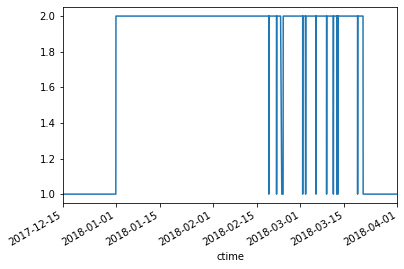

In [124]:
n_unique_per_timestamp = df_rough_meta_all.groupby(['ctime','extension']).count().groupby(['ctime']).count().sort_values('url').loc[:,'url']
n_unique_per_timestamp = n_unique_per_timestamp.sort_index()

n_unique_per_timestamp.plot()
plt.xlim(datetime.datetime(2017,12,15),datetime.datetime(2018,4,1))

In [132]:
# Individually check when a file is missing
timestamp_is_present = df_rough_meta_all.groupby(['ctime','extension']).count().groupby(['ctime','extension']).count().loc[:,'url']

# Split by filetype
timestamp_is_present_H5 = timestamp_is_present.loc[timestamp_is_present.index.get_level_values(1) == '.H5']
timestamp_is_present_HDF5 = timestamp_is_present.loc[timestamp_is_present.index.get_level_values(1) != '.H5']

# remove filetype index
timestamp_is_present_H5.index = timestamp_is_present_H5.index.get_level_values(0)
timestamp_is_present_HDF5.index = timestamp_is_present_HDF5.index.get_level_values(0)

# Resample
timestamp_is_present_H5_resampled = timestamp_is_present_H5.resample('900S').sum().fillna(0)
timestamp_is_present_HDF5_resampled = timestamp_is_present_HDF5.resample('900S').sum().fillna(0)

# replace index with datetimeindex
timestamp_is_present_HDF5_resampled.index = pd.DatetimeIndex(timestamp_is_present_HDF5_resampled.index)
timestamp_is_present_H5_resampled.index = pd.DatetimeIndex(timestamp_is_present_H5_resampled.index)

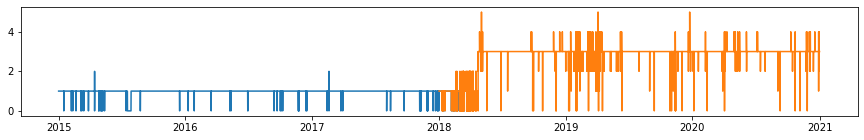

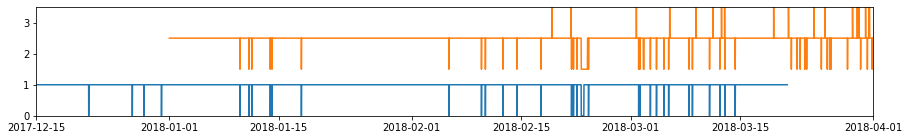

In [161]:
plt.figure(figsize=(15,2))
plt.plot(timestamp_is_present_H5_resampled)
plt.plot(timestamp_is_present_HDF5_resampled)
plt.show()

plt.figure(figsize=(15,2))
plt.plot(timestamp_is_present_H5_resampled)
plt.plot(timestamp_is_present_HDF5_resampled+1.5)
plt.xlim(datetime.datetime(2017,12,15),datetime.datetime(2018,4,1))
plt.ylim(0,3.5)
plt.show()

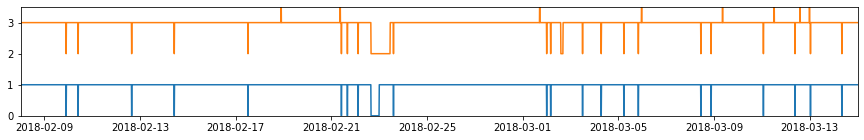

In [165]:

plt.figure(figsize=(15,2))
plt.plot(timestamp_is_present_H5_resampled)
plt.plot(timestamp_is_present_HDF5_resampled+2)
plt.xlim(datetime.datetime(2018,2,8),datetime.datetime(2018,3,15))
plt.ylim(0,3.5)
plt.show()

In [153]:
(timestamp_is_present_HDF5_resampled - timestamp_is_present_H5_resampled) 

ctime
2015-01-01 00:00:00   NaN
2015-01-01 00:15:00   NaN
2015-01-01 00:30:00   NaN
2015-01-01 00:45:00   NaN
2015-01-01 01:00:00   NaN
                       ..
2020-12-31 22:45:00   NaN
2020-12-31 23:00:00   NaN
2020-12-31 23:15:00   NaN
2020-12-31 23:30:00   NaN
2020-12-31 23:45:00   NaN
Freq: 900S, Name: url, Length: 210432, dtype: float64

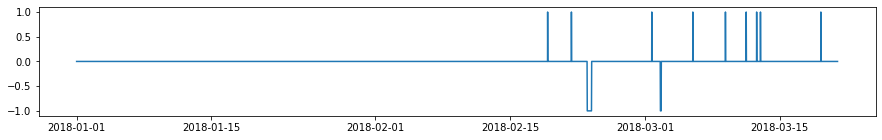

In [163]:
plt.figure(figsize=(15,2))
plt.plot(timestamp_is_present_HDF5_resampled - timestamp_is_present_H5_resampled)


# Compare when files are missing

In [130]:
timestamp_is_present_H5_resampled

ctime
2015-01-01 00:00:00    1.0
2015-01-01 00:15:00    1.0
2015-01-01 00:30:00    1.0
2015-01-01 00:45:00    1.0
2015-01-01 01:00:00    1.0
                      ... 
2018-03-20 22:45:00    1.0
2018-03-20 23:00:00    1.0
2018-03-20 23:15:00    1.0
2018-03-20 23:30:00    1.0
2018-03-20 23:45:00    1.0
Freq: 900S, Name: url, Length: 112800, dtype: float64

# Helper functions
